<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/Graduate_Project_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time

import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import ensemble, metrics
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal=",").drop_duplicates()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [4]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 75.83 Mb (46.0% reduction)


- The problem at hand appears to have a misalignment between the frequency of the features and the desired output, which is the percentage of Silica Concentrate (% Silica Concentrate). It is important to note that individual records do not predict the average % Silica Concentrate. Instead, it is the cumulative effect of all parameters over a period of time that results in the averaged % Silica Concentrate.

- From an industrial perspective, it is proposed to group and average all the records based on the % Silica Concentrate in order to address this issue. This approach can be perceived as a shortcut, but it aligns with the industrial understanding of the problem and provides a more meaningful analysis. By consolidating the data in this manner, we can capture the combined impact of various parameters on the averaged % Silica Concentrate.

In [5]:
# Grouping and averaging values by % Silica Concentrate
flotation_grpby = flotation.groupby(['% Silica Concentrate']).mean()

# Extracting % Silica Concentrate values
y = flotation_grpby.index.values.tolist()

# Removing % Iron Concentrate column as it is highly correlated with % Silica Concentrate (0.8)
flotation_grpby = flotation_grpby.drop(columns='% Iron Concentrate')

# Feature Scaling
min_max_scaler = MinMaxScaler()
flotation_scaled = min_max_scaler.fit_transform(flotation_grpby.values)
flotation_scaled = pd.DataFrame(flotation_scaled, columns=flotation_grpby.columns)

- Reducing dimensions is an effective approach to uncovering underlying variances.

In [6]:
# Dimensions reduction with Principal Components Analysis
pca = PCA(n_components=10)
flotation_pca = pca.fit_transform(flotation_scaled)

# Creation of the different datasets for training and testing
x_train, x_test, y_train, y_test = train_test_split(flotation_pca, y, test_size=0.8, random_state=42)

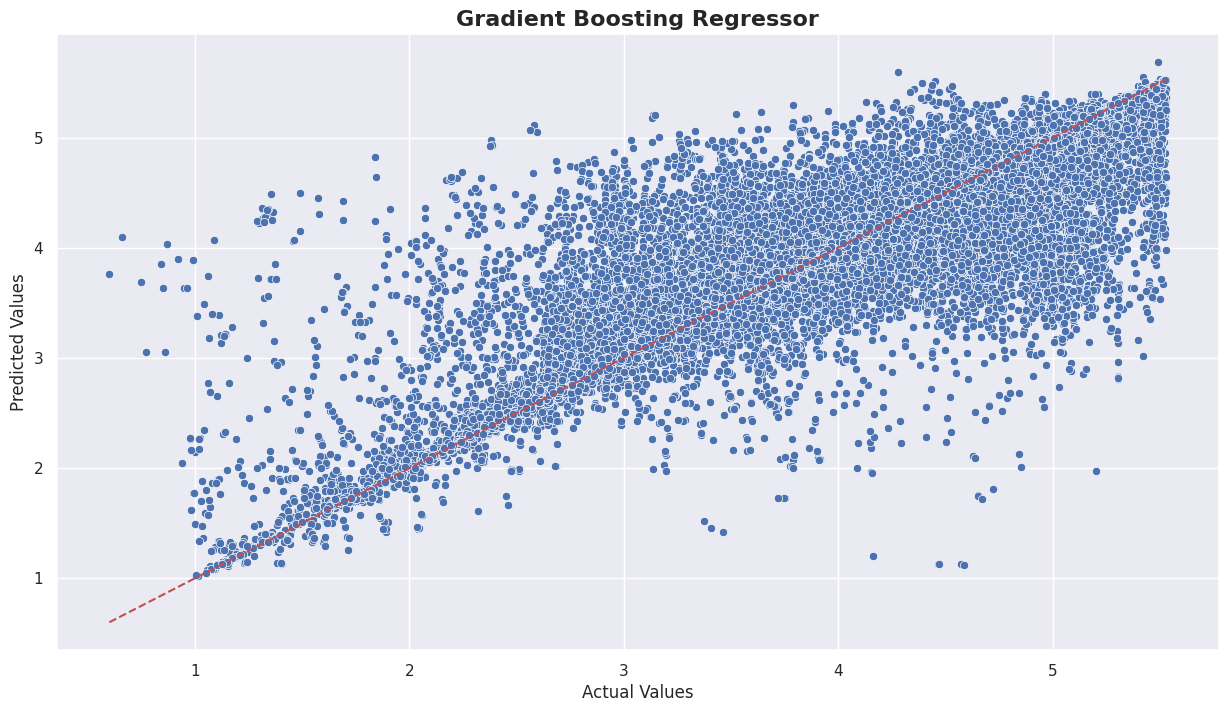

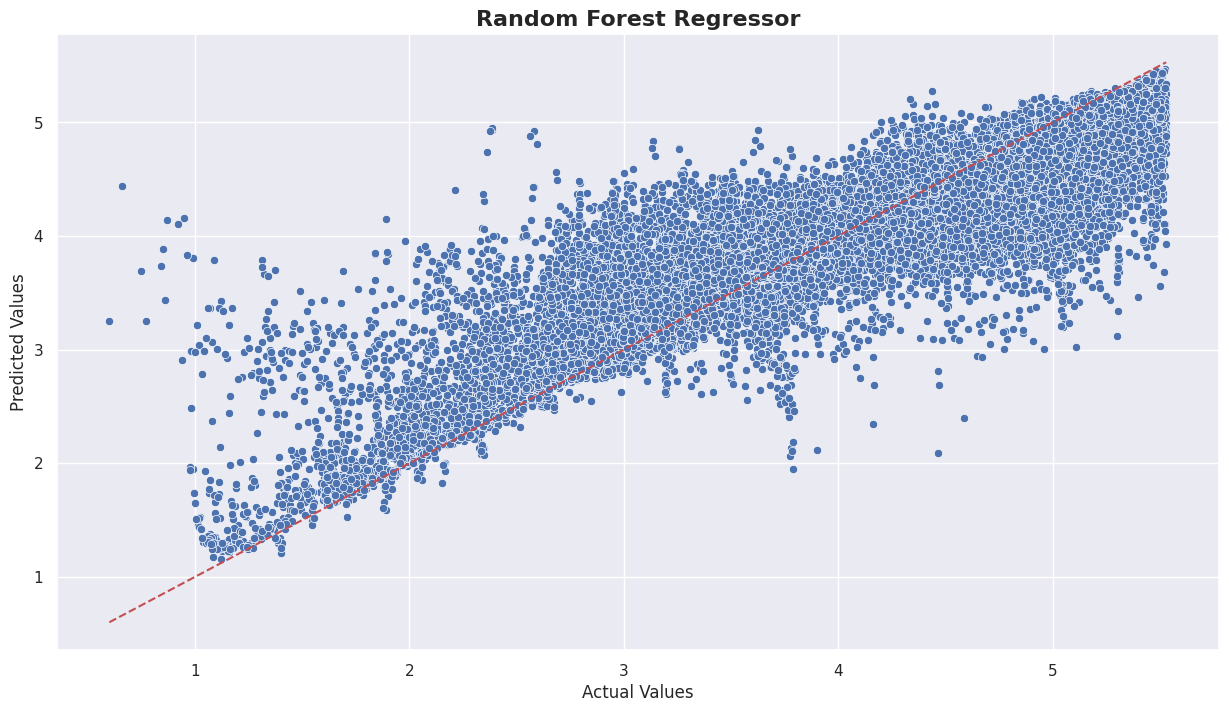

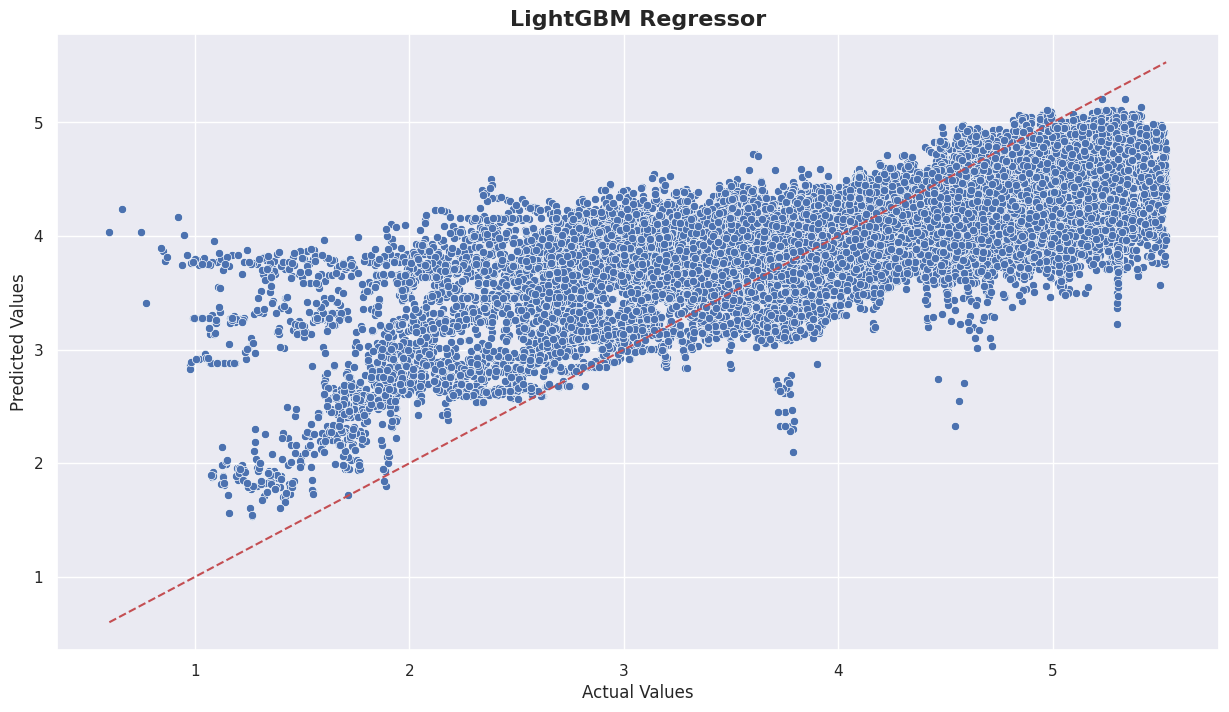

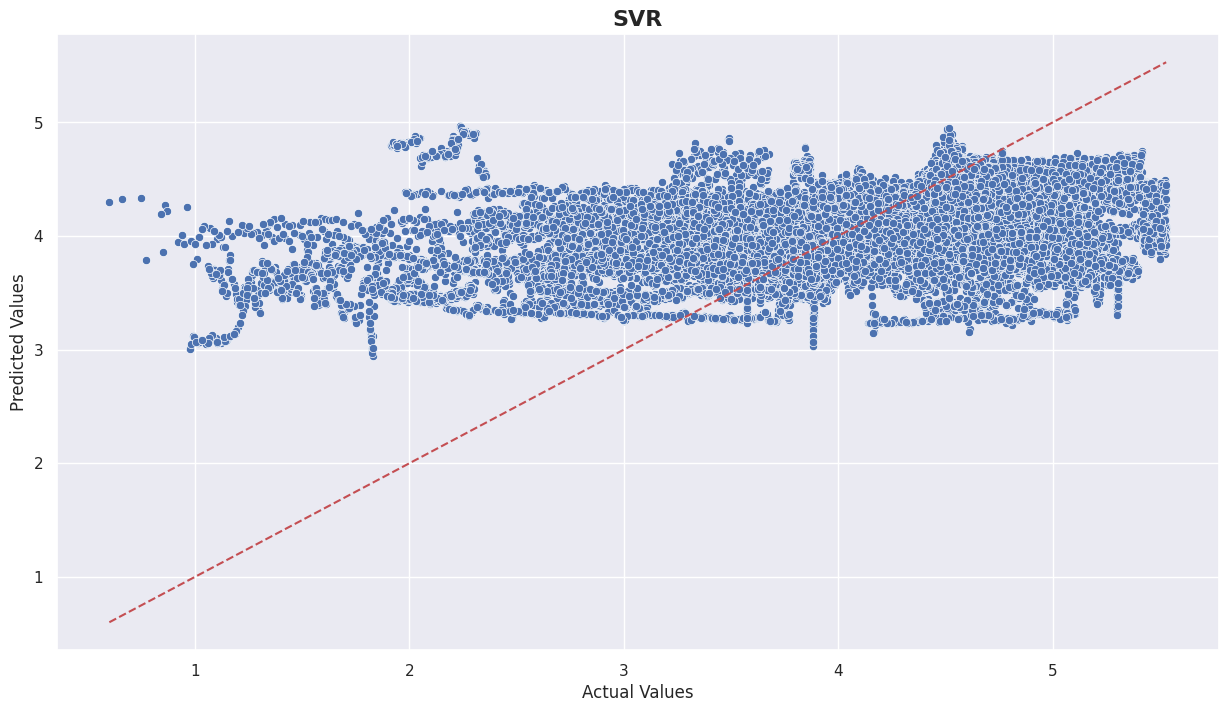

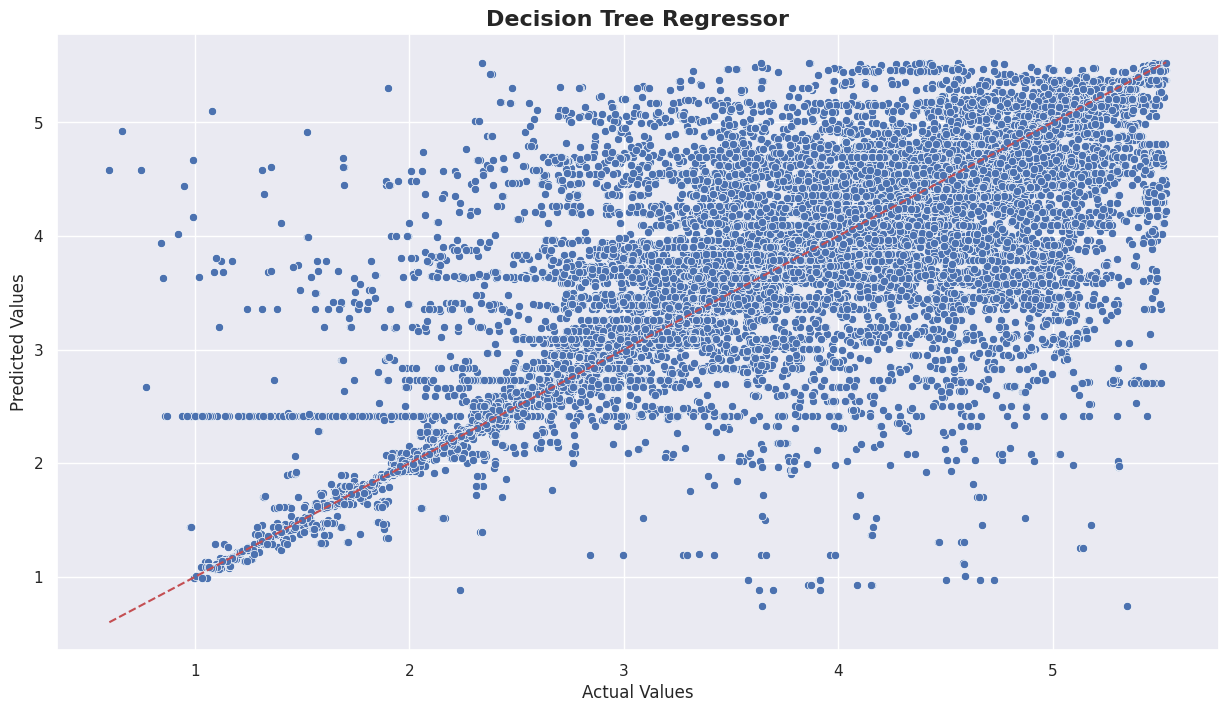

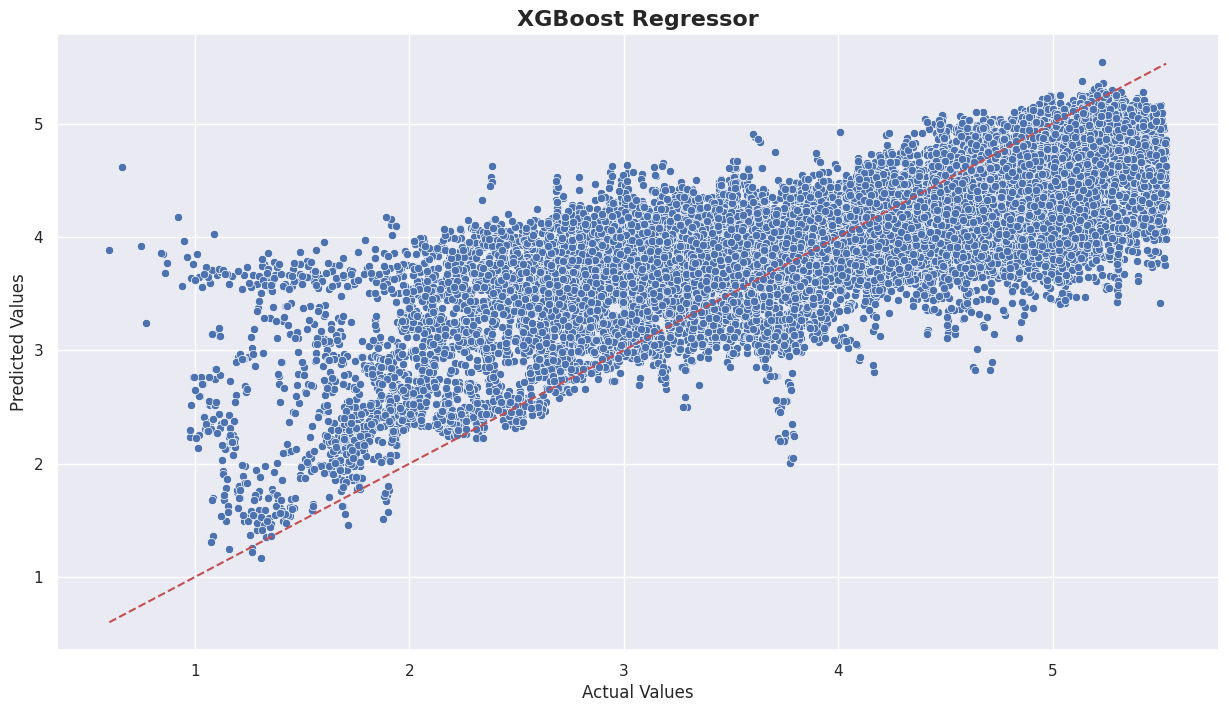

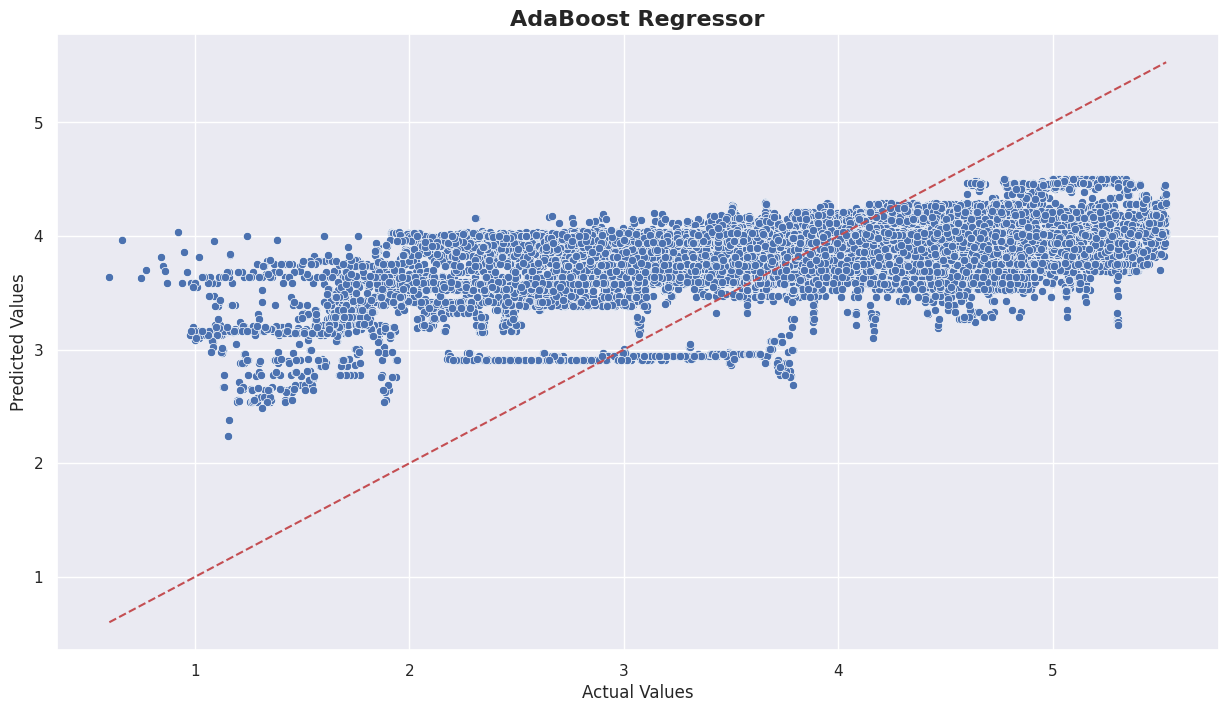

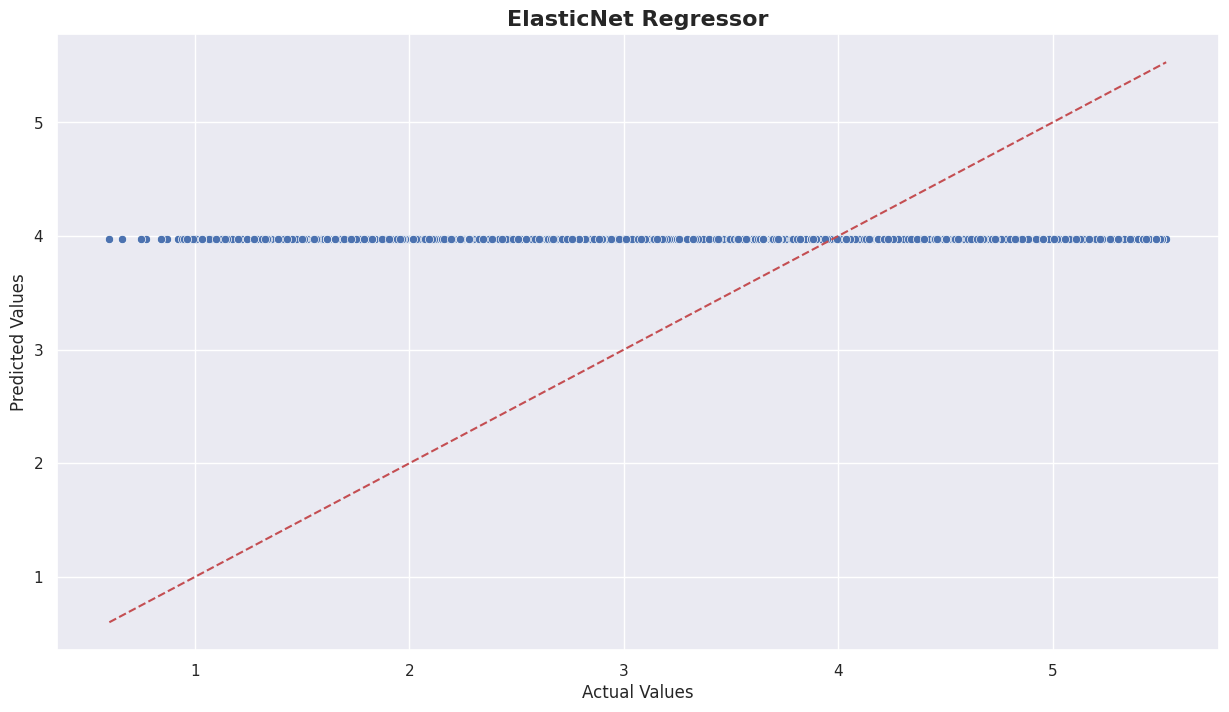

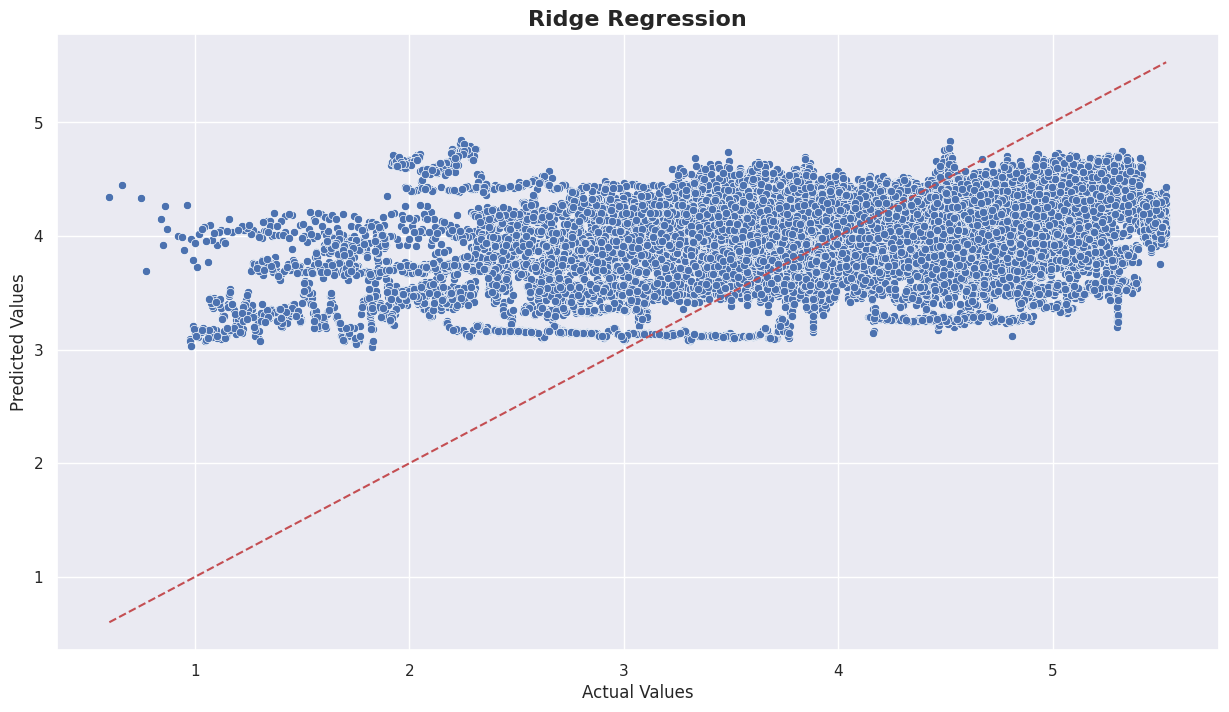

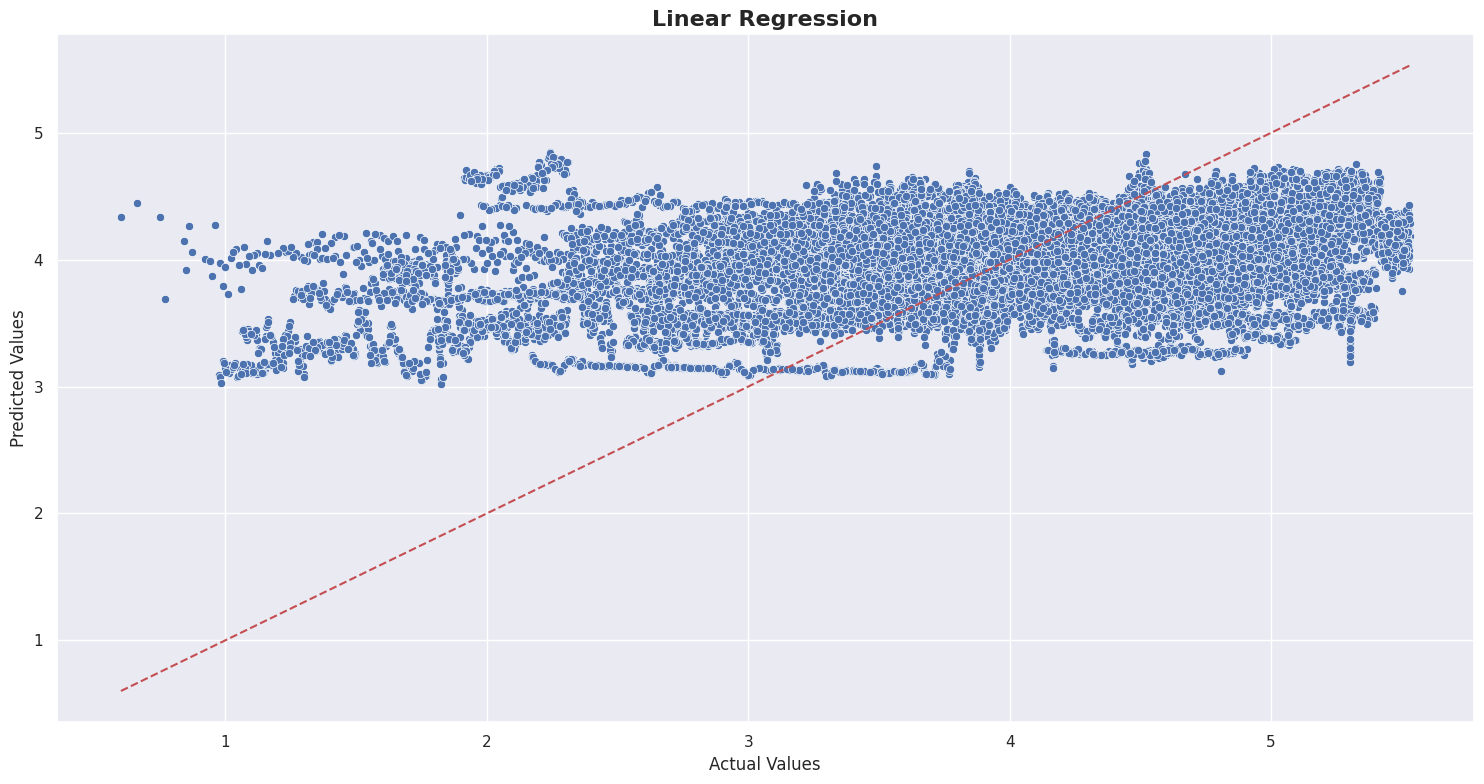

,Model,R-squared (Test dataset),MSE (Test dataset),Training Time,Inference Time
0,Gradient Boosting Regressor,0.758386,0.161882,29.541240,0.678499
1,Random Forest Regressor,0.789290,0.141176,15.045879,0.985729
2,LightGBM Regressor,0.492190,0.340233,1.922628,0.157393
3,SVR,0.086508,0.612040,5.067284,14.770020
4,Decision Tree Regressor,0.605489,0.264322,0.241567,0.007175
5,XGBoost Regressor,0.566217,0.290635,1.675592,0.052152
6,AdaBoost Regressor,0.188453,0.543737,5.269728,0.649479
7,ElasticNet Regressor,-0.000230,0.670155,0.013529,0.001929
8,Ridge Regression,0.108093,0.597578,0.007482,0.000859
9,Linear Regression,0.108081,0.597586,0.025392,0.002918


In [13]:
models = [
    {
        'name': 'Gradient Boosting Regressor',
        'model': ensemble.GradientBoostingRegressor(
            n_estimators=120,
            max_depth=16,
            learning_rate=0.1,
            criterion='squared_error'
        )
    },
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressor(
            n_estimators=120,
            max_depth=16,
            criterion='squared_error'
        )
    },
    {
        'name': 'LightGBM Regressor',
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05
        )
    },
    {
        'name': 'SVR',
        'model': SVR(kernel='linear')
    },
    {
        'name': 'Decision Tree Regressor',
        'model': DecisionTreeRegressor(
            max_depth=16,
            criterion='poisson'
        )
    },
    {
        'name': 'XGBoost Regressor',
        'model': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1
        )
    },
    {
        'name': 'AdaBoost Regressor',
        'model': AdaBoostRegressor(
            n_estimators=120,
            learning_rate=0.1,
            loss='linear'
        )
    },
    {
        'name': 'ElasticNet Regressor',
        'model': ElasticNet(
            alpha=0.5,
            l1_ratio=0.5
        )
    },
    {
        'name': 'Ridge Regression',
        'model': Ridge(
            alpha=0.5,
            solver='auto'
        )
    },
    {
        'name': 'Linear Regression',
        'model': LinearRegression()
    }
]

# Lists to store metric values and execution times
model_names = []
r_squared_values = []
mse_values = []
execution_times = []

for model in models:
    model_name = model['name']
    model_instance = model['model']

    # Model training
    start_time = time.time()
    model_instance.fit(x_train, y_train)
    training_time = time.time() - start_time

    # Model performance on test data
    start_time = time.time()
    y_pred = model_instance.predict(x_test)
    inference_time = time.time() - start_time

    # Calculate metrics
    r_squared = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)

    # Append metric values and execution times
    model_names.append(model_name)
    r_squared_values.append(r_squared)
    mse_values.append(mse)
    execution_times.append({
        'Training Time': training_time,
        'Inference Time': inference_time
    })

    # Plotting predicted vs. actual values
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(model_name, fontsize=16, fontweight='bold')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

data = {
    'Model': model_names,
    'R-squared (Test dataset)': r_squared_values,
    'MSE (Test dataset)': mse_values,
    'Training Time': [t['Training Time'] for t in execution_times],
    'Inference Time': [t['Inference Time'] for t in execution_times]
    }

df = pd.DataFrame(data)
df

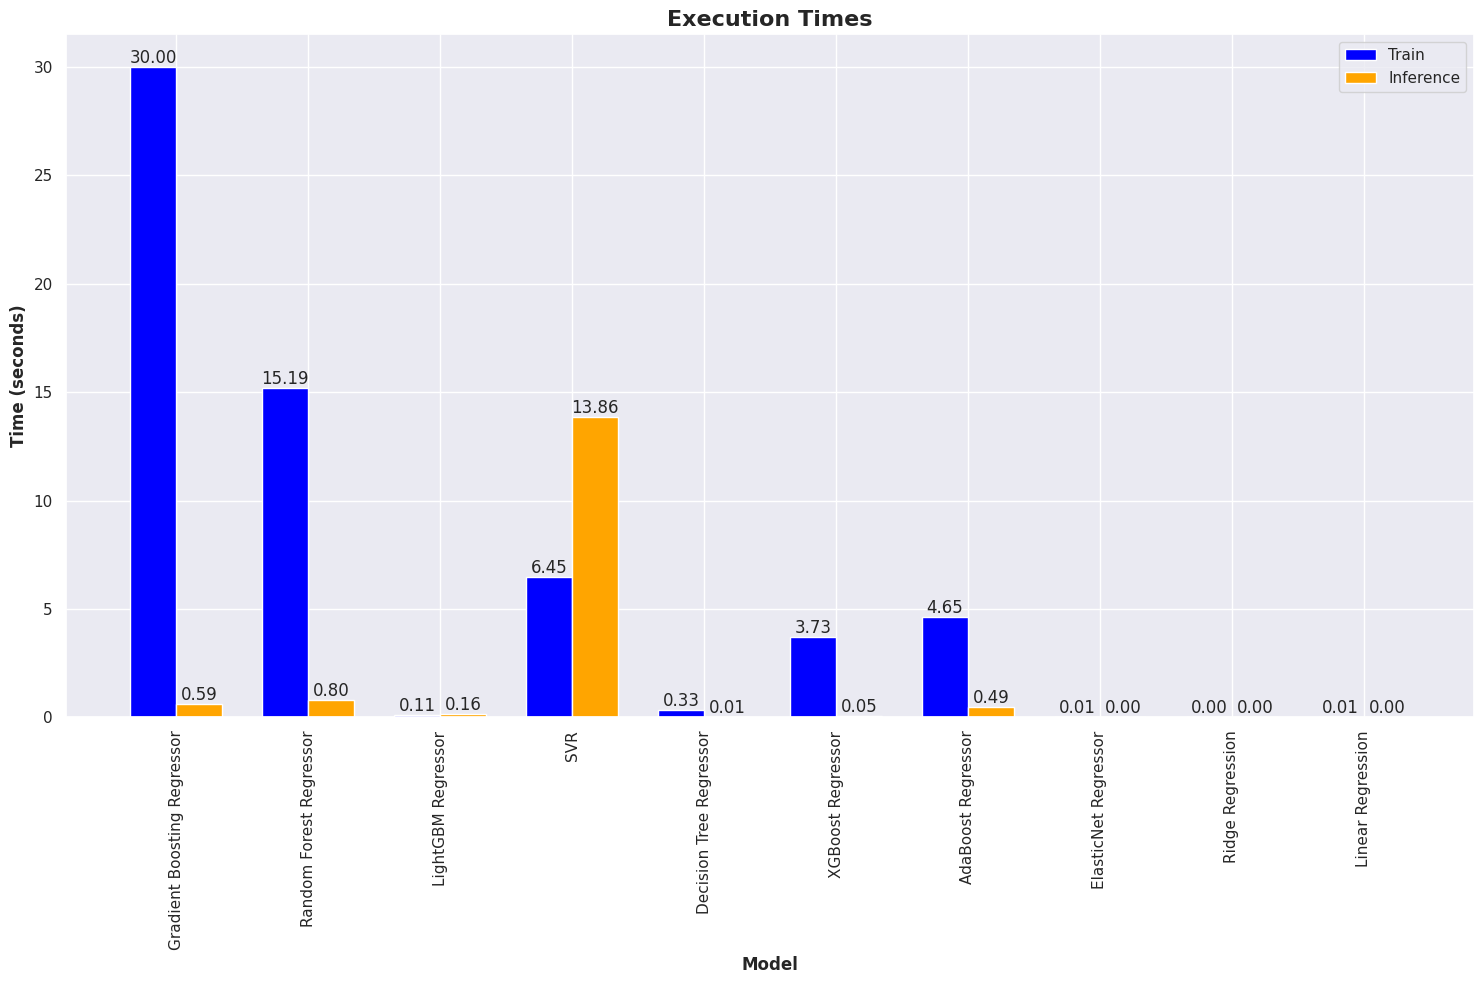

In [8]:
plt.figure(figsize=(15, 10))

execution_times_df = pd.DataFrame(execution_times, index=model_names)

bar_width = 0.35
index = range(len(model_names))

plt.bar(index, execution_times_df.iloc[:, 0], label='Train', color='blue', width=bar_width)
plt.bar([i + bar_width for i in index], execution_times_df.iloc[:, 1], label='Inference', color='orange', width=bar_width)

plt.title("Execution Times", fontsize=16, fontweight='bold')
plt.xlabel("Model", fontweight='bold')
plt.ylabel("Time (seconds)", fontweight='bold')
plt.xticks([i + bar_width/2 for i in index], model_names, rotation=90)
plt.legend()

# Add execution time labels
for i, row in enumerate(execution_times_df.iterrows()):
    model_name, execution_time = row
    plt.text(i, execution_time[0], f"{execution_time[0]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, execution_time[1], f"{execution_time[1]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


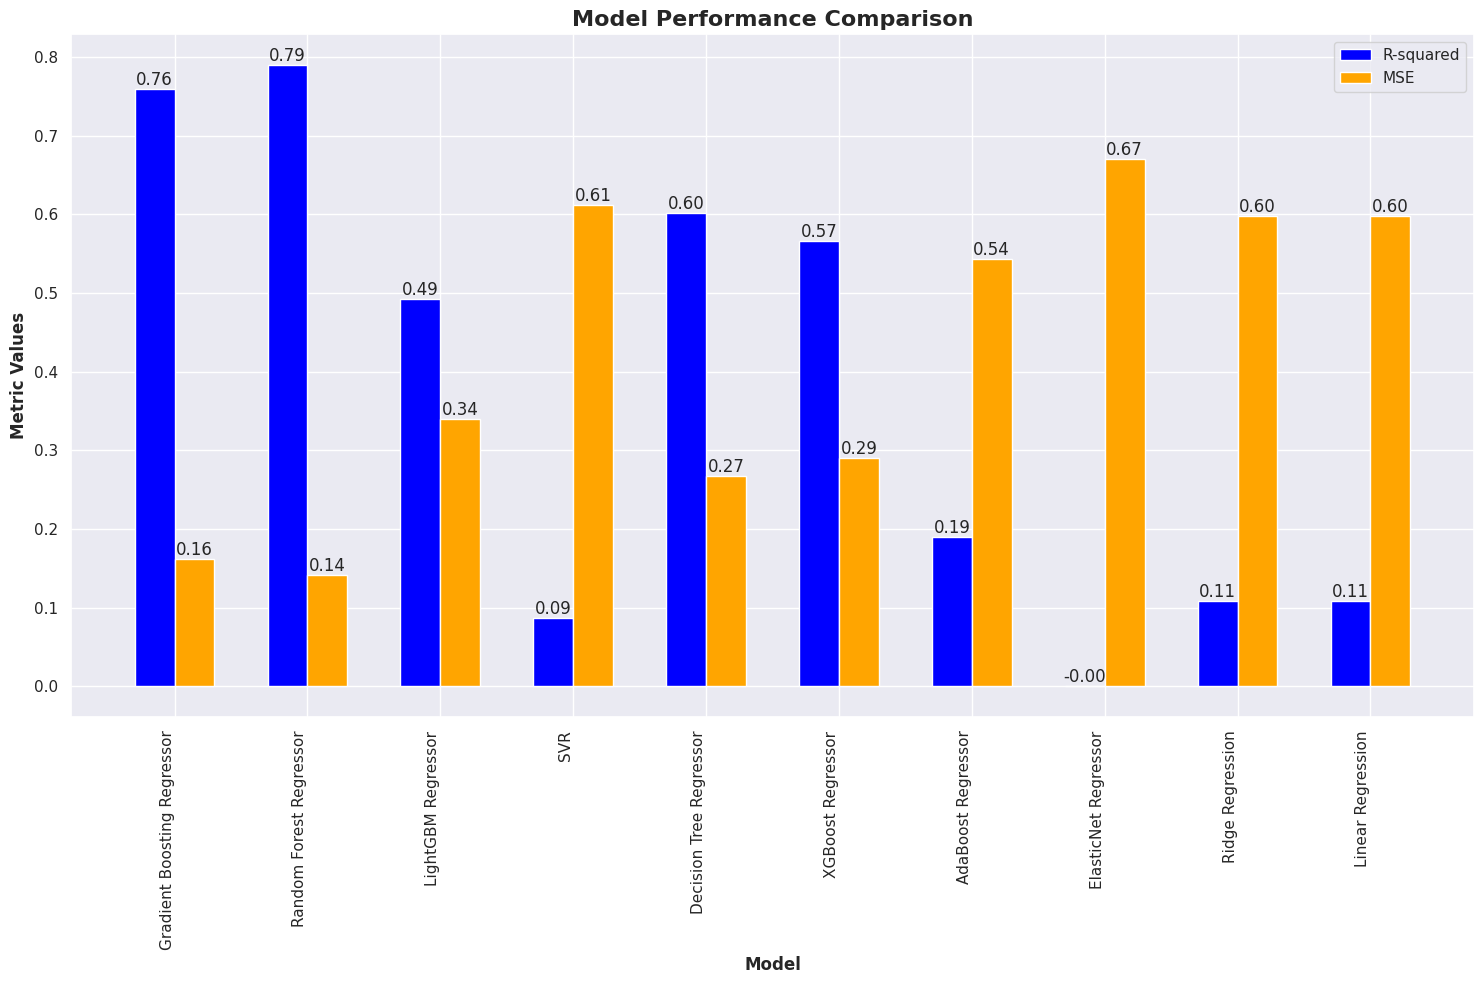

In [9]:
plt.figure(figsize=(15, 10))

bar_width = 0.30
index = np.arange(len(models))

plt.bar(index, r_squared_values, bar_width, label='R-squared', color='blue')
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')

for i, value in enumerate(r_squared_values):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

for i, value in enumerate(mse_values):
    plt.text(i + bar_width, value, f"{value:.2f}", ha='center', va='bottom')

plt.xlabel("Model", fontweight='bold')
plt.ylabel("Metric Values", fontweight='bold')
plt.title("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, model_names, rotation=90, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

After analyzing the performance of various regression models on the flotation dataset, here is a conclusion:

1. **Gradient Boosting Regressor**: This model performs well, with reasonably high accuracy in predicting the target variable. However, it has a longer training time compared to other models.

2. **Random Forest Regressor**: This model demonstrates good predictive power, outperforming other models in terms of accuracy. It also has a relatively faster training time.

3. **LightGBM Regressor**: While this model has the fastest training and inference times, it falls short in terms of accuracy compared to other models. It may not capture complex relationships in the data effectively.

4. **SVR (Support Vector Regressor)**: The SVR model shows limited predictive capability, with lower accuracy and a longer inference time compared to other models. It may not be suitable for real-time predictions.

5. **Decision Tree Regressor**: This model exhibits reasonably good performance, with moderate accuracy and fast training and inference times.

6. **XGBoost Regressor**: While this model shows decent accuracy, it is not as accurate as the top-performing models. However, it has reasonable training and inference times.

7. **AdaBoost Regressor**: The AdaBoost model has lower accuracy compared to other models, indicating its limitations in capturing the underlying patterns in the data. It also has a relatively longer training time.

8. **ElasticNet Regressor**: This model demonstrates poor performance, with low accuracy and a high mean squared error. It may not be suitable for flotation dataset.

9. **Ridge Regression**: Similar to ElasticNet, the Ridge Regression model performs poorly in accurately predicting the target variable. It may not capture the underlying patterns effectively.

10. **Linear Regression**: This model shows performance similar to Ridge Regression, with limited accuracy and high mean squared error.

Based on the analysis, **Random Forest Regressor emerges as the top-performing model due to its higher accuracy compared to other models while maintaining reasonable training and inference times**.